In [1]:
%cd ..

/misc/vlgscratch4/LakeGroup/wentao/multimodal-baby


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(12,12), 'axes.grid': True, 'axes.facecolor': 'white', 'figure.facecolor': 'white', 'font.family': 'monospace', 'font.size': 10})
from PIL import Image
from collections import namedtuple, defaultdict
import itertools
from operator import attrgetter
from multimodal.multimodal_data_module import MultiModalSAYCamDataModule
from multimodal.multimodal import TextEncoder, MultiModalModel, LanguageModel
from multimodal.multimodal_lit import MultiModalLitModel
from multimodal.multimodal_data_module import PAD_TOKEN_ID, UNK_TOKEN_ID, SOS_TOKEN_ID, EOS_TOKEN_ID
from ngram import NGramModel
from train import _setup_parser

from math import exp

/usr/local/stow/python-3.9/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [3]:
class SumData(namedtuple('SumDataTuple', ['cnt', 'vector', 'loss'])):
    """
    data structure to aggregate count, vector, loss
    """
    @property
    def mean_vector(self):
        return self.vector / np.expand_dims(self.cnt, -1)

    @property
    def mean_loss(self):
        return self.loss / self.cnt

    @property
    def ppl(self):
        return exp(self.mean_loss)

    def __add__(self, b):
        return SumData(
            cnt = self.cnt + b.cnt,
            vector = self.vector + b.vector,
            loss = self.loss + b.loss,
        )

    def __sub__(self, b):
        return SumData(
            cnt = self.cnt - b.cnt,
            vector = self.vector - b.vector,
            loss = self.loss - b.loss,
        )

    def to_numpy(self):
        return SumData(
            cnt = self.cnt,
            vector = self.vector.cpu().numpy(),
            loss = self.loss,
        )

def zero_sum_data(shape=()):
    return SumData(
        cnt = np.zeros(shape, dtype=int),
        vector = np.zeros(shape + (hidden_dim,)),
        loss = np.zeros(shape),
    )

def zero_sum_data_like(sum_data):
    return zero_sum_data(shape=sum_data.cnt.shape)

def zero_sum_datas_like(sum_datas):
    return [zero_sum_data_like(sum_data) for sum_data in sum_datas]

def list_add(a, b):
    return [x + y for x, y in zip(a, b)]

def list_sub(a, b):
    return [x - y for x, y in zip(a, b)]

class Item(namedtuple('ItemTuple', ['token_id', 'pos', 'values'])):
    """
    token_id: token index
    pos: pos tag
    values: list of SumData
    """

    @property
    def word(self):
        return idx2word[self.token_id]

    @property
    def format_str(self):
        return f'{self.word:<10} {self.pos:<4} {self.values[0].cnt:5}'

In [4]:
# printing utilities

def print_perplexities(items, print_indices):
    """
    items: list of items
    print_indices: token indices to print
    """
    if not items:
        return

    for item in items:
        for value in item.values:
            assert value.cnt == item.values[0].cnt

    formatter = lambda prefix, values: f'{prefix:<21}: ' + ' '.join(f'{value:9.3f}' for value in values)
    for idx in print_indices:
        item = items[idx]
        print(formatter(item.format_str, (value.ppl for value in item.values)))

    print()

    tot_values = zero_sum_datas_like(items[0].values)
    tot_ppl_formatter = lambda prefix: formatter(f'{prefix:<14} {tot_values[0].cnt:>6}', (value.ppl for value in tot_values))

    for item in filter(lambda item: item.token_id != PAD_TOKEN_ID, items):
        tot_values = list_add(tot_values, item.values)
    print(tot_ppl_formatter('ppl'))

    for item in filter(lambda item: item.token_id == SOS_TOKEN_ID, items):
        tot_values = list_sub(tot_values, item.values)
    print(tot_ppl_formatter('ppl_wo_sos'))

    for item in filter(lambda item: item.token_id == EOS_TOKEN_ID, items):
        tot_values = list_sub(tot_values, item.values)
    print(tot_ppl_formatter('ppl_wo_sos_eos'))

    print()

In [5]:
# plotting utilities

def plot_dendrogram(items):
    """
    linkage clustering and dendrogram plotting
    items: list of Item containing n_items items
    """
    from scipy.cluster.hierarchy import dendrogram, linkage

    n_items = len(items)
    vectors = np.array([item.values[0].mean_vector for item in items])

    Z = linkage(vectors, method='average', metric='cosine')  # of shape (number of merges = n_items - 1, 4)

    def llf(index):
        if index < n_items:
            item = items[index]
            return item.format_str + ' ' + (f'{item.values[0].ppl:8.2f}' if len(item.values) == 1 else f'{item.values[0].ppl:8.2f}{item.values[1].ppl - item.values[0].ppl:+8.2f}')
        else:
            merge_index = index - n_items
            return f'{merge_index} {int(Z[merge_index, 3])} {Z[merge_index, 2]:.3f}'

    p = 10000

    plt.figure(figsize=(25 / 2, 0.3 * min(p, n_items))) # 0.1
    return dendrogram(
        Z,
        truncate_mode='lastp',
        p=p,
        orientation='left',
        leaf_rotation=0.,
        leaf_font_size=16.,
        leaf_label_func=llf,
    )

def get_tsne_coordinates(vectors):
    from sklearn.manifold import TSNE

    tsne = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate='auto', n_iter=1000, metric='cosine')
    points = tsne.fit_transform(vectors)
    return points

def pos_mapping(pos):
    pos = pos[:2]
    return pos

def plot_tsne(items):
    """
    t-SNE
    items: list of Item containing n_items items
    """

    n_items = len(items)
    vectors = np.array([item.values[0].mean_vector for item in items])

    points = get_tsne_coordinates(vectors)

    # plotting
    #plt.scatter(points[:, 0], points[:, 1], s=10)
    df = pd.DataFrame(points)
    df['word'] = [item.word for item in items]
    df['pos_tag'] = [pos_mapping(item.pos) for item in items]
    sns.scatterplot(data=df, x=0, y=1, hue='pos_tag', palette='tab20')
    for item, point in zip(items, points):
        plt.text(point[0], point[1], item.word)

In [6]:
# get counts, vectors, losses, pos tags

from tqdm import tqdm
from nltk.tag import pos_tag as pos_tagger

def build_ngram_model(N, vocab_size, train_dataloader):
    ngram_model = NGramModel(N, vocab_size)

    for x, y, y_len in tqdm(train_dataloader):
        y, y_len = y.to(device=device), y_len.to(device=device)
        ngram_model.update(y, y_len)

    return ngram_model

def get_token_pos_values(language_model, dataloader):
    hidden_dim = text_encoder.hidden_dim
    def torch_zero_sum_data():
        return SumData(
            cnt = np.array(0),
            vector = torch.zeros(hidden_dim, device=device),
            loss = np.array(0.),
        )

    s = [defaultdict(torch_zero_sum_data) for idx in range(vocab_size)]

    with torch.no_grad():
        for x, y, y_len in tqdm(dataloader):
            batch_size = y.size(0)
            utterance_idxes_list = [utterance[:length].tolist() for utterance, length in zip(y, y_len)]

            x, y, y_len = x.to(device=device), y.to(device=device), y_len.to(device=device)

            if isinstance(language_model, LanguageModel):
                image_features = None
                if language_model.text_encoder.captioning:
                    image_features = lit_model.vision_encoder(x)
                    if lit_model.model.normalize_features:
                        image_features = F.normalize(image_features, p=2, dim=1)  # normalize image features
                loss, outputs, logits, labels = language_model.calculate_ce_loss(y, y_len, image_features=image_features, tokenwise=True)
            elif isinstance(language_model, NGramModel):
                loss = language_model.calculate_ce_loss(y, y_len, tokenwise=True)
                outputs = torch.zeros(*(y.shape + (hidden_dim,)), dtype=torch.float, device=device)
            else:
                assert False, f"Unknown language_model class {type(language_model)}"
            if (isinstance(language_model, LanguageModel) and language_model.text_encoder.regressional) or isinstance(language_model, NGramModel): # loss, logits, labels is shifted
                # pad loss with preceeding 0
                loss = F.pad(loss, (1, 0))

            for i in range(batch_size):
                # pos tagging
                utterance_idxes = utterance_idxes_list[i]
                utterance_words = [text_encoder.idx2word[idx] for idx in utterance_idxes]
                tagging_indices, tagging_words = zip(*[(index, word) for index, word in enumerate(utterance_words) if utterance_idxes[index] not in [SOS_TOKEN_ID, EOS_TOKEN_ID]])
                _, pos_tags = zip(*pos_tagger(tagging_words))
                utterance_pos_tags = ['.'] * len(utterance_idxes)
                for index, pos in zip(tagging_indices, pos_tags):
                    utterance_pos_tags[index] = pos

                for j in range(len(utterance_idxes)):
                    idx = utterance_idxes[j]
                    pos_tag = utterance_pos_tags[j]
                    s[idx][pos_tag] += SumData(1, outputs[i, j].detach(), loss[i, j].item())

    s = [{pos_tag: sum_data.to_numpy() for pos_tag, sum_data in d.items()} for d in s]

    return s

In [7]:
# load model from checkpoint

parser = _setup_parser()
args = parser.parse_args("")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = MultiModalSAYCamDataModule(args)
data.prepare_data()
data.setup()

# select from list of checkpoints
checkpoint = {
    "lm": [
        "checkpoints/lm_text_encoder_lstm_embedding_dim_32_tie_True_bias_True_dropout_i_0.0_dropout_o_0.1_batch_size_256_drop_last_True_optimizer_AdamW_lr_0.03_weight_decay_0.03_seed_0/epoch=8.ckpt",
        "checkpoints/lm_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.05_seed_0/epoch=58.ckpt",
        "checkpoints/lm_captioning_False_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.05_seed_0/epoch=150.ckpt",
        "checkpoints/lm_captioning_True_text_encoder_lstm_embedding_dim_512_tie_True_bias_True_dropout_i_0.5_dropout_o_0.0_batch_size_8_drop_last_True_optimizer_AdamW_lr_0.003_weight_decay_0.05_seed_0/epoch=53.ckpt",
        "checkpoints/lm_text_encoder_cbow_embedding_dim_32_tie_False_bias_False_dropout_i_0.0_dropout_o_0.1_batch_size_128_drop_last_True_optimizer_AdamW_lr_0.01_weight_decay_0.04_seed_0/epoch=10.ckpt",
    ],
    "multimodal": [
        "checkpoints/multimodal_sim_mean_embedding_type_spatial_text_encoder_embedding_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_False_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.0003_weight_decay_0.0_val_batch_size_16_seed_0/epoch=10.ckpt",
        "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.2_val_batch_size_16_seed_0/epoch=91.ckpt",
        "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.0_dropout_o_0.1_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=29.ckpt",
        "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.2_val_batch_size_16_seed_0/epoch=85.ckpt",
        "checkpoints/multimodal_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=121.ckpt",
    ],
    "joint": [
        "checkpoints/joint_lambda_mm_1.0_lambda_lm_1.0_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.003_weight_decay_0.05_val_batch_size_16_seed_0/epoch=159.ckpt",
        "checkpoints/joint_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_0.003_weight_decay_0.05_val_batch_size_16_seed_0/epoch=78.ckpt",
        "checkpoints/joint_lambda_mm_1.0_lambda_lm_1.0_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=187.ckpt",
        "checkpoints/joint_lambda_mm_0.5_lambda_lm_0.5_sim_mean_embedding_type_flat_text_encoder_lstm_embedding_dim_512_dropout_i_0.5_dropout_o_0.0_fix_temperature_True_temperature_0.07_batch_size_8_optimizer_AdamW_lr_5e-05_weight_decay_0.05_val_batch_size_16_seed_0/epoch=194.ckpt",
    ],
}["lm"][2]

print_dict_args = False
if print_dict_args:
    ckpt = torch.load(checkpoint)
    print(ckpt['hyper_parameters']['args'])

lit_model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
print(lit_model.args)
lit_model.to(device)
text_encoder = lit_model.text_encoder
hidden_dim = text_encoder.hidden_dim
word2idx = text_encoder.word2idx
idx2word = text_encoder.idx2word

vocab = text_encoder.vocab
vocab_size = len(vocab)
print(f'vocab_size = {vocab_size}')
# check consistency between vocab and idx2word
for idx in range(vocab_size):
    assert idx in idx2word
lit_model.eval()

eval_ngram = False
if eval_ngram:
    ngram_model = build_ngram_model(3, vocab_size, data.train_dataloader())

/home/ww2135/.local/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:73: LightningDeprecationWarning: DataModule property `train_transforms` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


Calling prepare_data!
SAYCam transcripts have already been downloaded. Skipping this step.
Transcripts have already been renamed. Skipping this step.
Transcripts have already been preprocessed. Skipping this step.
Training frames have already been extracted. Skipping this step.
Training metadata files have already been created . Skipping this step.
Evaluation frames have already been extracted. Skipping this step.
Evaluation metadata files have already been created . Skipping this step.
Vocabulary file already exists. Skipping this step.
Calling setup!
{'logger': True, 'checkpoint_callback': True, 'enable_checkpointing': True, 'default_root_dir': None, 'gradient_clip_val': None, 'gradient_clip_algorithm': None, 'process_position': 0, 'num_nodes': 1, 'num_processes': 1, 'devices': None, 'gpus': 1, 'auto_select_gpus': False, 'tpu_cores': None, 'ipus': None, 'log_gpu_memory': None, 'progress_bar_refresh_rate': None, 'enable_progress_bar': True, 'overfit_batches': 0.0, 'track_grad_norm': -

In [8]:
# get sum values (counts, vector representations, losses) across the training set
# in the form of [{pos_tag: sum_data for pos_tag in occured_pos_tags_of_word_idx} for idx in range(vocab_size)]
token_pos_values = get_token_pos_values(ngram_model if eval_ngram else lit_model.language_model, data.train_dataloader() if 1 else data.val_dataloader()[0])

def get_values_and_items(token_pos_values):
    # construct token_pos_items from token_pos_values
    token_pos_items = [
        Item(token_id=token_id,
             pos=pos,
             values=[value],
        )
        for token_id, pos_values in enumerate(token_pos_values)
        for pos, value in pos_values.items()
    ]

    # aggregate sum values for words
    token_values = [sum(d.values(), start=zero_sum_data()) for d in token_pos_values]
    # construct token_items from token_values
    token_items = [
        Item(token_id=token_id,
             # set the POS tag of a word as the most frequent POS tag
             pos=max(pos_values.items(), key=lambda pos_value: pos_value[1].cnt.item(), default=('.', None))[0],
             values=[token_value],
        )
        for token_id, (pos_values, token_value) in enumerate(zip(token_pos_values, token_values))
    ]

    return token_pos_items, token_values, token_items

token_pos_items, token_values, token_items = get_values_and_items(token_pos_values)

# SumData in which every item is a numpy array with first dimension indexed by word idx
token_values_ = SumData(*map(np.array, zip(*token_values)))
# get mean vectors
vectors = token_values_.mean_vector

# or directly use the embedding vectors
use_embedding_vectors = False
if use_embedding_vectors:
    assert False, "Currently cannot use embedding vectors if we want to see results of different pos tags"
    vectors = text_encoder.embedding.weight.detach().cpu().numpy()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8289/8289 [01:12<00:00, 114.13it/s]
/tmp/ipykernel_403066/2323242671.py:7: RuntimeWarning: invalid value encountered in true_divide
  return self.vector / np.expand_dims(self.cnt, -1)


In [9]:
def items_to_dict(items):
    return {item[:2]: item.values for item in items}

def dict_to_items(d):
    return [Item(*key, values=values) for key, values in d.items()]

def concat_items(*items_list):
    dict_list = list(map(items_to_dict, items_list))
    keys = (item[:2] for item in items_list[0])
    return [Item(*key, values=list(itertools.chain.from_iterable(d[key] for d in dict_list))) for key in keys]

token_pos_values_list = [token_pos_values]
#token_pos_values_list = [token_pos_values] + token_pos_values_list
tmp_res = [(_,) + get_values_and_items(_) for _ in token_pos_values_list if _ is not None]
print_perplexities(concat_items(*[_[3] for _ in tmp_res]), range(20))

<pad>      .        0:       nan
<unk>      NN     294:   204.006
<sos>      .    33155:     1.000
<eos>      .    32888:     1.936
alright    NN     645:    74.250
lets       NNS    126:   249.271
change     VB      58:    45.082
your       PRP$  1590:    10.238
nappy      JJ     126:    10.501
though     IN     121:    98.545
first      RB     106:   208.606
yeah       NN    4849:    10.491
oh         UH    1250:    31.100
you        PRP   8544:     6.455
wanna      VBP    291:    58.014
do         VBP   1830:    31.419
it         PRP   3467:     7.157
i          NN    2300:    26.196
think      VBP    531:     9.227
there      EX    1905:    26.650

ppl            234024:    12.411
ppl_wo_sos     200869:    18.809
ppl_wo_sos_eos 167981:    29.355



/tmp/ipykernel_403066/2323242671.py:11: RuntimeWarning: invalid value encountered in true_divide
  return self.loss / self.cnt


In [10]:
# cosine matrices for some tested words

np.set_printoptions(precision=2, suppress=True)

def split_tokens(inp):
    tokens = inp.split()
    token_ids = []
    not_found = []
    for s in tokens:
        try:
            token_ids.append(word2idx[s])
        except KeyError:
            not_found.append(s)
    if not_found:
        print('not found:', ' '.join(not_found))
        return []
    return token_ids

def cosine_matrix(V):
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    return V @ V.T

# cosine matrices
print('cosine matrices:')
print()
for inp in [
    "red orange yellow green blue purple brown black white",
    "boy girl mommy daddy grandpa grandma",
]:
    print('words:', inp)
    token_ids = split_tokens(inp)
    if not token_ids:
        continue

    V = vectors[token_ids]
    print(cosine_matrix(V))
    print()

# cosine matrices for the differentiations (vector1 - vector0)
print('cosine matrices for the differentiations:')
print()
for inp in [
    "do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives",
    "do did go went play played get got eat ate have had make made look looked fly flew drive drove stand stood crawl crawled",
    "do doing go going play playing get getting eat eating have having look looking fly flying drive driving stand standing crawl crawling",
    "do don't does doesn't did didn't should shouldn't has hasn't have haven't will won't",
    "boy girl mommy daddy grandpa grandma",
]:
    print('words:', inp)
    token_ids = split_tokens(inp)
    if not token_ids:
        continue
    if len(token_ids) % 2 != 0:
        print('Error: number of tokens should be even.')
        continue

    V = vectors[token_ids]
    V = V.reshape((V.shape[0] // 2, 2,) + V.shape[1:])
    V = V[:, 1] - V[:, 0]
    print(cosine_matrix(V))
    print()

cosine matrices:

words: red orange yellow green blue purple brown black white
[[1.   0.71 0.78 0.77 0.71 0.76 0.58 0.63 0.45]
 [0.71 1.   0.64 0.64 0.59 0.62 0.5  0.59 0.4 ]
 [0.78 0.64 1.   0.79 0.75 0.83 0.63 0.67 0.5 ]
 [0.77 0.64 0.79 1.   0.85 0.82 0.67 0.74 0.56]
 [0.71 0.59 0.75 0.85 1.   0.78 0.62 0.61 0.47]
 [0.76 0.62 0.83 0.82 0.78 1.   0.62 0.68 0.49]
 [0.58 0.5  0.63 0.67 0.62 0.62 1.   0.65 0.62]
 [0.63 0.59 0.67 0.74 0.61 0.68 0.65 1.   0.63]
 [0.45 0.4  0.5  0.56 0.47 0.49 0.62 0.63 1.  ]]

words: boy girl mommy daddy grandpa grandma
[[1.   0.79 0.36 0.17 0.4  0.38]
 [0.79 1.   0.38 0.22 0.36 0.35]
 [0.36 0.38 1.   0.24 0.68 0.6 ]
 [0.17 0.22 0.24 1.   0.27 0.28]
 [0.4  0.36 0.68 0.27 1.   0.73]
 [0.38 0.35 0.6  0.28 0.73 1.  ]]

cosine matrices for the differentiations:

words: do does go goes play plays get gets eat eats have has make makes look looks fly flies drive drives
[[ 1.    0.    0.27  0.19  0.21  0.29  0.25  0.11  0.02  0.  ]
 [ 0.    1.    0.15  0.21  0.16

In [11]:
# treat pos tags with the same two character prefix as the same pos tag
zero_sum_datas_ = zero_sum_datas_like(token_pos_items[0].values)
item_dict = defaultdict(lambda: zero_sum_datas_)
for item in token_pos_items:
    key = (item.token_id, pos_mapping(item.pos))
    item_dict[key] = list_add(item_dict[key], item.values)
token_pos2_items = [Item(*key, values=values) for key, values in item_dict.items()]

# select items; must not select items with cnt=0 which contain untrained vectors
sorted_token_items = sorted(token_items, key=lambda item: item.values[0].cnt, reverse=True)
sorted_token_pos_items = sorted(token_pos_items, key=lambda item: item.values[0].cnt, reverse=True)
noun_items = [item for item in sorted_token_pos_items if item.pos.startswith('NN')]
verb_items = [item for item in sorted_token_pos_items if item.pos.startswith('VB')]
selected_items = sorted_token_items[:200]
#selected_items = noun_items[:200]
#selected_items = verb_items[:200]
#selected_items = noun_items[:50] + verb_items[:50] + noun_items[50:100] + verb_items[50:100]
n_items = len(selected_items)
print('number of selected items:', n_items)

# check some selected items
for item in selected_items[:100]:
    print(item.format_str)
print()
for word in ['look', 'need', 'draw']:
    for item in selected_items:
        if item.word == word:
            print(item.format_str)

number of selected items: 200
<sos>      .    33155
<eos>      .    32888
you        PRP   8544
the        DT    5735
yeah       NN    4849
a          DT    4467
to         TO    4452
and        CC    3761
it         PRP   3467
want       VBP   2775
we         PRP   2757
is         VBZ   2604
i          NN    2300
that       DT    2016
are        VBP   1962
there      EX    1905
go         VB    1885
do         VBP   1830
can        MD    1781
okay       NN    1739
on         IN    1711
in         IN    1611
your       PRP$  1590
have       VBP   1532
that's     NN    1506
this       DT    1370
put        VB    1270
oh         UH    1250
one        CD    1198
all        DT    1145
of         IN    1117
see        VB    1055
now        RB    1022
some       DT     974
what       WP     940
here       RB     933
it's       NN     930
get        VB     903
there's    VB     881
right      NN     861
don't      VBP    859
ok         NN     811
with       IN     768
me         PRP    749
go

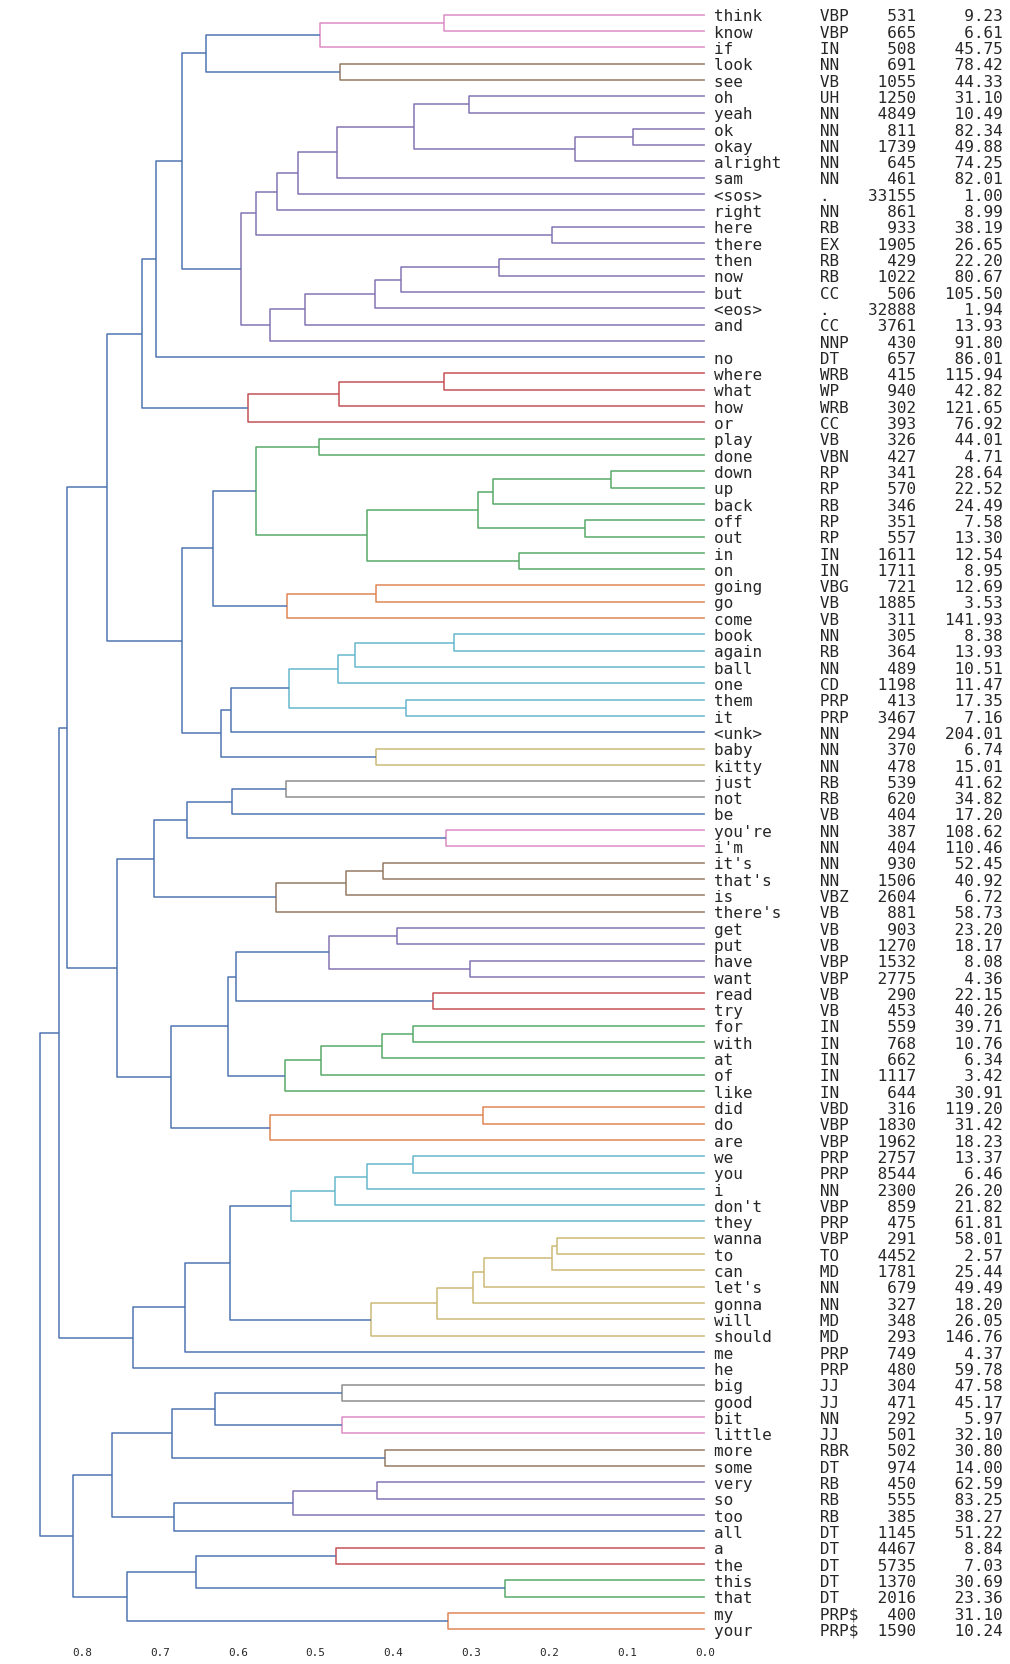

In [12]:
_ = plot_dendrogram(selected_items[:100])

/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ww2135/.local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


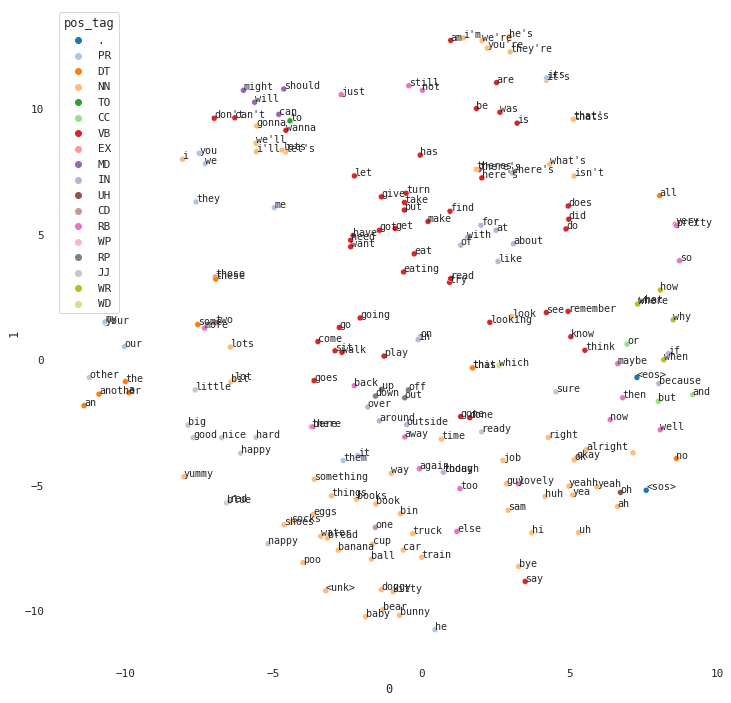

In [13]:
plot_tsne(selected_items[:200])